# _*Qiskit Aqua: qGANs for Loading Random Distributions*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ
- <sup>[2]</sup>ETH Zurich

### Introduction
Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state: 
$$\lvert g_{\theta}\rangle = \sum\limits_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}}\lvert{j}\rangle$$
where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\vert j\rangle$. 

The aim of the qGAN training is to generate a state $\lvert g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to <a href="https://arxiv.org/abs/1904.00043">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

In [3]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import absolute_import, division, print_function

import numpy as np

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline


import time

start = time.time()

from torch import optim
from qiskit.aqua.algorithms.adaptive.qgan.discriminator import DiscriminatorNet

from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms.adaptive.qgan.qgan import QGAN

from qiskit.aqua import aqua_globals, QuantumInstance

from qiskit import BasicAer

### Load the Training Data
First, we need to load the $k$-dimensional training data samples (here k=1). <br/>
Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [4]:
# Number training data samples
N = 10000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

### Initialize the qGAN
The qGAN consists of a quantum generator $G_{\theta}$, a variational quantum circuit, and a classical discriminator $D_{\phi}$, a neural network. <br/>
To implement the quantum generator, we choose a depth-$1$ variational form that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should $>1$ becaue the higher the circuit depth the because higher circuit depths enable the representation of more complex structures.<br/>
The classical discriminator is given by a $3$-layer neural network that applies linear transformations, leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. Notably, the neural network is implemented with PyTorch. Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.<br/>
Here, both networks are updated with the ADAM optimization algorithm.

In [7]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 1000

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)

# Set quantum instance to run the quantum generator
backend = BasicAer.get_backend('statevector_simulator')
qgan.set_quantum_instance(QuantumInstance(backend=backend, shots=batch_size, coupling_map=None, circuit_caching=False))


# Set entangler map
entangler_map = [[0, 1]]
        
# Set variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * 1e-2
# Set an initial state for the generator circuit
init_dist = UniformDistribution(np.sum(num_qubits), low=bounds[0], high=bounds[1])
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(sum(num_qubits), var_form, init_params,
                                        initial_distribution=init_dist, low=bounds[0], high=bounds[1])
# Set generator optimizer
g_optimizer = ADAM(maxiter=1, tol=1e-6, lr=1e-5, beta_1=0.9, beta_2=0.99, noise_factor=1e-6,
                 eps=1e-10, amsgrad=True)
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_optimizer=g_optimizer)

# Set discriminator network
d_net = DiscriminatorNet(n_features=k)
# Set discriminator optimizer
d_optimizer = optim.Adam(d_net.parameters(), lr=1e-5, amsgrad=True)
# Set classical discriminator neural network
qgan.set_discriminator(discriminator_net=d_net, discriminator_optimizer=d_optimizer)

### Run the qGAN Training
During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

In [8]:
# Run qGAN
qgan.run()

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

Epoch 1/3000...
Loss Discriminator:  0.6977
Loss Generator:  0.6754
Relative Entropy:  0.1783
Epoch 2/3000...
Loss Discriminator:  0.6964
Loss Generator:  0.6806
Relative Entropy:  0.1783
Epoch 3/3000...
Loss Discriminator:  0.6948
Loss Generator:  0.6832
Relative Entropy:  0.1784
Epoch 4/3000...
Loss Discriminator:  0.6935
Loss Generator:  0.6851
Relative Entropy:  0.1784
Epoch 5/3000...
Loss Discriminator:  0.6923
Loss Generator:  0.687
Relative Entropy:  0.1784
Epoch 6/3000...
Loss Discriminator:  0.6912
Loss Generator:  0.6864
Relative Entropy:  0.1783
Epoch 7/3000...
Loss Discriminator:  0.6901
Loss Generator:  0.6865
Relative Entropy:  0.1783
Epoch 8/3000...
Loss Discriminator:  0.689
Loss Generator:  0.6879
Relative Entropy:  0.1782
Epoch 9/3000...
Loss Discriminator:  0.6875
Loss Generator:  0.6894
Relative Entropy:  0.1781
Epoch 10/3000...
Loss Discriminator:  0.6868
Loss Generator:  0.6924
Relative Entropy:  0.1781
Epoch 11/3000...
Loss Discriminator:  0.6857
Loss Generator: 

Loss Discriminator:  0.6708
Loss Generator:  0.7357
Relative Entropy:  0.1727
Epoch 89/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7352
Relative Entropy:  0.1726
Epoch 90/3000...
Loss Discriminator:  0.6652
Loss Generator:  0.7354
Relative Entropy:  0.1726
Epoch 91/3000...
Loss Discriminator:  0.6684
Loss Generator:  0.7378
Relative Entropy:  0.1725
Epoch 92/3000...
Loss Discriminator:  0.6674
Loss Generator:  0.736
Relative Entropy:  0.1724
Epoch 93/3000...
Loss Discriminator:  0.6722
Loss Generator:  0.7374
Relative Entropy:  0.1723
Epoch 94/3000...
Loss Discriminator:  0.6683
Loss Generator:  0.7358
Relative Entropy:  0.1723
Epoch 95/3000...
Loss Discriminator:  0.6685
Loss Generator:  0.735
Relative Entropy:  0.1722
Epoch 96/3000...
Loss Discriminator:  0.6689
Loss Generator:  0.7364
Relative Entropy:  0.1721
Epoch 97/3000...
Loss Discriminator:  0.6707
Loss Generator:  0.7377
Relative Entropy:  0.1721
Epoch 98/3000...
Loss Discriminator:  0.6672
Loss Generator:  0.7335


Loss Discriminator:  0.6697
Loss Generator:  0.7356
Relative Entropy:  0.1669
Epoch 175/3000...
Loss Discriminator:  0.6693
Loss Generator:  0.7335
Relative Entropy:  0.1668
Epoch 176/3000...
Loss Discriminator:  0.6709
Loss Generator:  0.734
Relative Entropy:  0.1667
Epoch 177/3000...
Loss Discriminator:  0.6686
Loss Generator:  0.7374
Relative Entropy:  0.1667
Epoch 178/3000...
Loss Discriminator:  0.6696
Loss Generator:  0.7355
Relative Entropy:  0.1666
Epoch 179/3000...
Loss Discriminator:  0.6691
Loss Generator:  0.7315
Relative Entropy:  0.1665
Epoch 180/3000...
Loss Discriminator:  0.6706
Loss Generator:  0.7336
Relative Entropy:  0.1665
Epoch 181/3000...
Loss Discriminator:  0.6713
Loss Generator:  0.7375
Relative Entropy:  0.1664
Epoch 182/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7347
Relative Entropy:  0.1663
Epoch 183/3000...
Loss Discriminator:  0.6685
Loss Generator:  0.7344
Relative Entropy:  0.1663
Epoch 184/3000...
Loss Discriminator:  0.6679
Loss Generato

Loss Discriminator:  0.6705
Loss Generator:  0.7328
Relative Entropy:  0.1612
Epoch 261/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7339
Relative Entropy:  0.1611
Epoch 262/3000...
Loss Discriminator:  0.6682
Loss Generator:  0.7332
Relative Entropy:  0.1611
Epoch 263/3000...
Loss Discriminator:  0.6695
Loss Generator:  0.7336
Relative Entropy:  0.161
Epoch 264/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7347
Relative Entropy:  0.1609
Epoch 265/3000...
Loss Discriminator:  0.6712
Loss Generator:  0.7355
Relative Entropy:  0.1609
Epoch 266/3000...
Loss Discriminator:  0.6678
Loss Generator:  0.7334
Relative Entropy:  0.1608
Epoch 267/3000...
Loss Discriminator:  0.6704
Loss Generator:  0.7329
Relative Entropy:  0.1608
Epoch 268/3000...
Loss Discriminator:  0.6719
Loss Generator:  0.7311
Relative Entropy:  0.1607
Epoch 269/3000...
Loss Discriminator:  0.6723
Loss Generator:  0.7344
Relative Entropy:  0.1606
Epoch 270/3000...
Loss Discriminator:  0.6714
Loss Generator:

Loss Discriminator:  0.6697
Loss Generator:  0.7295
Relative Entropy:  0.1557
Epoch 347/3000...
Loss Discriminator:  0.6723
Loss Generator:  0.7304
Relative Entropy:  0.1556
Epoch 348/3000...
Loss Discriminator:  0.6682
Loss Generator:  0.7327
Relative Entropy:  0.1556
Epoch 349/3000...
Loss Discriminator:  0.6681
Loss Generator:  0.734
Relative Entropy:  0.1555
Epoch 350/3000...
Loss Discriminator:  0.6718
Loss Generator:  0.732
Relative Entropy:  0.1554
Epoch 351/3000...
Loss Discriminator:  0.6711
Loss Generator:  0.7328
Relative Entropy:  0.1554
Epoch 352/3000...
Loss Discriminator:  0.6705
Loss Generator:  0.7324
Relative Entropy:  0.1553
Epoch 353/3000...
Loss Discriminator:  0.67
Loss Generator:  0.7314
Relative Entropy:  0.1552
Epoch 354/3000...
Loss Discriminator:  0.6725
Loss Generator:  0.7337
Relative Entropy:  0.1552
Epoch 355/3000...
Loss Discriminator:  0.6698
Loss Generator:  0.7328
Relative Entropy:  0.1551
Epoch 356/3000...
Loss Discriminator:  0.6691
Loss Generator: 

Loss Discriminator:  0.6706
Loss Generator:  0.7302
Relative Entropy:  0.1503
Epoch 433/3000...
Loss Discriminator:  0.6721
Loss Generator:  0.7326
Relative Entropy:  0.1502
Epoch 434/3000...
Loss Discriminator:  0.672
Loss Generator:  0.7296
Relative Entropy:  0.1502
Epoch 435/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7299
Relative Entropy:  0.1501
Epoch 436/3000...
Loss Discriminator:  0.6713
Loss Generator:  0.7327
Relative Entropy:  0.15
Epoch 437/3000...
Loss Discriminator:  0.6718
Loss Generator:  0.7331
Relative Entropy:  0.15
Epoch 438/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.7294
Relative Entropy:  0.1499
Epoch 439/3000...
Loss Discriminator:  0.6722
Loss Generator:  0.7277
Relative Entropy:  0.1499
Epoch 440/3000...
Loss Discriminator:  0.6714
Loss Generator:  0.7282
Relative Entropy:  0.1498
Epoch 441/3000...
Loss Discriminator:  0.6721
Loss Generator:  0.7324
Relative Entropy:  0.1497
Epoch 442/3000...
Loss Discriminator:  0.6709
Loss Generator:  

Loss Discriminator:  0.6727
Loss Generator:  0.7261
Relative Entropy:  0.145
Epoch 519/3000...
Loss Discriminator:  0.6742
Loss Generator:  0.7299
Relative Entropy:  0.145
Epoch 520/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7302
Relative Entropy:  0.1449
Epoch 521/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7267
Relative Entropy:  0.1449
Epoch 522/3000...
Loss Discriminator:  0.6747
Loss Generator:  0.729
Relative Entropy:  0.1448
Epoch 523/3000...
Loss Discriminator:  0.671
Loss Generator:  0.729
Relative Entropy:  0.1447
Epoch 524/3000...
Loss Discriminator:  0.6731
Loss Generator:  0.7271
Relative Entropy:  0.1447
Epoch 525/3000...
Loss Discriminator:  0.6715
Loss Generator:  0.729
Relative Entropy:  0.1446
Epoch 526/3000...
Loss Discriminator:  0.6712
Loss Generator:  0.7289
Relative Entropy:  0.1446
Epoch 527/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7286
Relative Entropy:  0.1445
Epoch 528/3000...
Loss Discriminator:  0.6712
Loss Generator:  0

Loss Discriminator:  0.6735
Loss Generator:  0.7268
Relative Entropy:  0.1399
Epoch 605/3000...
Loss Discriminator:  0.672
Loss Generator:  0.7274
Relative Entropy:  0.1399
Epoch 606/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7276
Relative Entropy:  0.1398
Epoch 607/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7277
Relative Entropy:  0.1398
Epoch 608/3000...
Loss Discriminator:  0.6719
Loss Generator:  0.728
Relative Entropy:  0.1397
Epoch 609/3000...
Loss Discriminator:  0.6724
Loss Generator:  0.7261
Relative Entropy:  0.1396
Epoch 610/3000...
Loss Discriminator:  0.6726
Loss Generator:  0.7265
Relative Entropy:  0.1396
Epoch 611/3000...
Loss Discriminator:  0.6706
Loss Generator:  0.7236
Relative Entropy:  0.1395
Epoch 612/3000...
Loss Discriminator:  0.6747
Loss Generator:  0.725
Relative Entropy:  0.1395
Epoch 613/3000...
Loss Discriminator:  0.6758
Loss Generator:  0.7294
Relative Entropy:  0.1394
Epoch 614/3000...
Loss Discriminator:  0.6733
Loss Generator:

Loss Discriminator:  0.6722
Loss Generator:  0.7236
Relative Entropy:  0.135
Epoch 691/3000...
Loss Discriminator:  0.6735
Loss Generator:  0.7242
Relative Entropy:  0.1349
Epoch 692/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7269
Relative Entropy:  0.1349
Epoch 693/3000...
Loss Discriminator:  0.6734
Loss Generator:  0.7267
Relative Entropy:  0.1348
Epoch 694/3000...
Loss Discriminator:  0.6752
Loss Generator:  0.7267
Relative Entropy:  0.1347
Epoch 695/3000...
Loss Discriminator:  0.6745
Loss Generator:  0.7264
Relative Entropy:  0.1347
Epoch 696/3000...
Loss Discriminator:  0.6721
Loss Generator:  0.725
Relative Entropy:  0.1346
Epoch 697/3000...
Loss Discriminator:  0.6726
Loss Generator:  0.7255
Relative Entropy:  0.1346
Epoch 698/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7274
Relative Entropy:  0.1345
Epoch 699/3000...
Loss Discriminator:  0.6735
Loss Generator:  0.7273
Relative Entropy:  0.1345
Epoch 700/3000...
Loss Discriminator:  0.6736
Loss Generator

Loss Discriminator:  0.6742
Loss Generator:  0.7251
Relative Entropy:  0.1301
Epoch 777/3000...
Loss Discriminator:  0.674
Loss Generator:  0.7247
Relative Entropy:  0.1301
Epoch 778/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7251
Relative Entropy:  0.13
Epoch 779/3000...
Loss Discriminator:  0.6747
Loss Generator:  0.7229
Relative Entropy:  0.13
Epoch 780/3000...
Loss Discriminator:  0.6759
Loss Generator:  0.7236
Relative Entropy:  0.1299
Epoch 781/3000...
Loss Discriminator:  0.6746
Loss Generator:  0.7267
Relative Entropy:  0.1299
Epoch 782/3000...
Loss Discriminator:  0.675
Loss Generator:  0.7241
Relative Entropy:  0.1298
Epoch 783/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7244
Relative Entropy:  0.1298
Epoch 784/3000...
Loss Discriminator:  0.6759
Loss Generator:  0.7226
Relative Entropy:  0.1297
Epoch 785/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7257
Relative Entropy:  0.1296
Epoch 786/3000...
Loss Discriminator:  0.6747
Loss Generator:  0

Loss Discriminator:  0.6768
Loss Generator:  0.7231
Relative Entropy:  0.1254
Epoch 863/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7219
Relative Entropy:  0.1254
Epoch 864/3000...
Loss Discriminator:  0.6767
Loss Generator:  0.7209
Relative Entropy:  0.1253
Epoch 865/3000...
Loss Discriminator:  0.6745
Loss Generator:  0.723
Relative Entropy:  0.1253
Epoch 866/3000...
Loss Discriminator:  0.6743
Loss Generator:  0.7236
Relative Entropy:  0.1252
Epoch 867/3000...
Loss Discriminator:  0.6766
Loss Generator:  0.7222
Relative Entropy:  0.1252
Epoch 868/3000...
Loss Discriminator:  0.6737
Loss Generator:  0.7217
Relative Entropy:  0.1251
Epoch 869/3000...
Loss Discriminator:  0.6751
Loss Generator:  0.7237
Relative Entropy:  0.1251
Epoch 870/3000...
Loss Discriminator:  0.6739
Loss Generator:  0.7237
Relative Entropy:  0.125
Epoch 871/3000...
Loss Discriminator:  0.6755
Loss Generator:  0.7226
Relative Entropy:  0.125
Epoch 872/3000...
Loss Discriminator:  0.6754
Loss Generator:

Loss Discriminator:  0.674
Loss Generator:  0.7194
Relative Entropy:  0.1209
Epoch 949/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7189
Relative Entropy:  0.1208
Epoch 950/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7243
Relative Entropy:  0.1208
Epoch 951/3000...
Loss Discriminator:  0.6784
Loss Generator:  0.7198
Relative Entropy:  0.1207
Epoch 952/3000...
Loss Discriminator:  0.6764
Loss Generator:  0.7199
Relative Entropy:  0.1207
Epoch 953/3000...
Loss Discriminator:  0.6755
Loss Generator:  0.7234
Relative Entropy:  0.1206
Epoch 954/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.721
Relative Entropy:  0.1206
Epoch 955/3000...
Loss Discriminator:  0.6736
Loss Generator:  0.7218
Relative Entropy:  0.1205
Epoch 956/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7214
Relative Entropy:  0.1205
Epoch 957/3000...
Loss Discriminator:  0.6738
Loss Generator:  0.7193
Relative Entropy:  0.1204
Epoch 958/3000...
Loss Discriminator:  0.678
Loss Generator:

Loss Discriminator:  0.6761
Loss Generator:  0.722
Relative Entropy:  0.1165
Epoch 1035/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7205
Relative Entropy:  0.1164
Epoch 1036/3000...
Loss Discriminator:  0.6772
Loss Generator:  0.7182
Relative Entropy:  0.1164
Epoch 1037/3000...
Loss Discriminator:  0.6793
Loss Generator:  0.7202
Relative Entropy:  0.1163
Epoch 1038/3000...
Loss Discriminator:  0.6761
Loss Generator:  0.7211
Relative Entropy:  0.1163
Epoch 1039/3000...
Loss Discriminator:  0.6753
Loss Generator:  0.7198
Relative Entropy:  0.1162
Epoch 1040/3000...
Loss Discriminator:  0.6773
Loss Generator:  0.7201
Relative Entropy:  0.1162
Epoch 1041/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7174
Relative Entropy:  0.1161
Epoch 1042/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7203
Relative Entropy:  0.1161
Epoch 1043/3000...
Loss Discriminator:  0.6765
Loss Generator:  0.7224
Relative Entropy:  0.116
Epoch 1044/3000...
Loss Discriminator:  0.6768
Loss 

Loss Discriminator:  0.6771
Loss Generator:  0.7179
Relative Entropy:  0.1122
Epoch 1120/3000...
Loss Discriminator:  0.6749
Loss Generator:  0.7201
Relative Entropy:  0.1122
Epoch 1121/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7209
Relative Entropy:  0.1121
Epoch 1122/3000...
Loss Discriminator:  0.6785
Loss Generator:  0.718
Relative Entropy:  0.1121
Epoch 1123/3000...
Loss Discriminator:  0.678
Loss Generator:  0.7162
Relative Entropy:  0.112
Epoch 1124/3000...
Loss Discriminator:  0.6781
Loss Generator:  0.7184
Relative Entropy:  0.112
Epoch 1125/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.7202
Relative Entropy:  0.1119
Epoch 1126/3000...
Loss Discriminator:  0.6798
Loss Generator:  0.7196
Relative Entropy:  0.1119
Epoch 1127/3000...
Loss Discriminator:  0.6771
Loss Generator:  0.7186
Relative Entropy:  0.1118
Epoch 1128/3000...
Loss Discriminator:  0.6769
Loss Generator:  0.7164
Relative Entropy:  0.1118
Epoch 1129/3000...
Loss Discriminator:  0.6764
Loss Ge

Loss Discriminator:  0.6769
Loss Generator:  0.7192
Relative Entropy:  0.1081
Epoch 1205/3000...
Loss Discriminator:  0.6773
Loss Generator:  0.7188
Relative Entropy:  0.1081
Epoch 1206/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7174
Relative Entropy:  0.108
Epoch 1207/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7185
Relative Entropy:  0.108
Epoch 1208/3000...
Loss Discriminator:  0.6778
Loss Generator:  0.7188
Relative Entropy:  0.1079
Epoch 1209/3000...
Loss Discriminator:  0.6774
Loss Generator:  0.7192
Relative Entropy:  0.1079
Epoch 1210/3000...
Loss Discriminator:  0.6801
Loss Generator:  0.7143
Relative Entropy:  0.1079
Epoch 1211/3000...
Loss Discriminator:  0.6763
Loss Generator:  0.7164
Relative Entropy:  0.1078
Epoch 1212/3000...
Loss Discriminator:  0.6774
Loss Generator:  0.7189
Relative Entropy:  0.1078
Epoch 1213/3000...
Loss Discriminator:  0.6782
Loss Generator:  0.7204
Relative Entropy:  0.1077
Epoch 1214/3000...
Loss Discriminator:  0.6776
Loss 

Loss Discriminator:  0.6777
Loss Generator:  0.7163
Relative Entropy:  0.1042
Epoch 1290/3000...
Loss Discriminator:  0.6787
Loss Generator:  0.7171
Relative Entropy:  0.1041
Epoch 1291/3000...
Loss Discriminator:  0.6765
Loss Generator:  0.7177
Relative Entropy:  0.1041
Epoch 1292/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7152
Relative Entropy:  0.104
Epoch 1293/3000...
Loss Discriminator:  0.6776
Loss Generator:  0.7174
Relative Entropy:  0.104
Epoch 1294/3000...
Loss Discriminator:  0.6791
Loss Generator:  0.7174
Relative Entropy:  0.1039
Epoch 1295/3000...
Loss Discriminator:  0.679
Loss Generator:  0.7145
Relative Entropy:  0.1039
Epoch 1296/3000...
Loss Discriminator:  0.6783
Loss Generator:  0.7161
Relative Entropy:  0.1038
Epoch 1297/3000...
Loss Discriminator:  0.677
Loss Generator:  0.7168
Relative Entropy:  0.1038
Epoch 1298/3000...
Loss Discriminator:  0.6768
Loss Generator:  0.7159
Relative Entropy:  0.1038
Epoch 1299/3000...
Loss Discriminator:  0.6783
Loss Ge

Loss Discriminator:  0.6784
Loss Generator:  0.7155
Relative Entropy:  0.1003
Epoch 1375/3000...
Loss Discriminator:  0.6775
Loss Generator:  0.7171
Relative Entropy:  0.1002
Epoch 1376/3000...
Loss Discriminator:  0.6791
Loss Generator:  0.7152
Relative Entropy:  0.1002
Epoch 1377/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7133
Relative Entropy:  0.1001
Epoch 1378/3000...
Loss Discriminator:  0.678
Loss Generator:  0.7176
Relative Entropy:  0.1001
Epoch 1379/3000...
Loss Discriminator:  0.6777
Loss Generator:  0.7168
Relative Entropy:  0.1
Epoch 1380/3000...
Loss Discriminator:  0.6804
Loss Generator:  0.7154
Relative Entropy:  0.1
Epoch 1381/3000...
Loss Discriminator:  0.6804
Loss Generator:  0.7134
Relative Entropy:  0.0999
Epoch 1382/3000...
Loss Discriminator:  0.6782
Loss Generator:  0.7145
Relative Entropy:  0.0999
Epoch 1383/3000...
Loss Discriminator:  0.6786
Loss Generator:  0.7172
Relative Entropy:  0.0999
Epoch 1384/3000...
Loss Discriminator:  0.6796
Loss Gene

Loss Discriminator:  0.6796
Loss Generator:  0.7135
Relative Entropy:  0.0962
Epoch 1460/3000...
Loss Discriminator:  0.6783
Loss Generator:  0.7147
Relative Entropy:  0.0962
Epoch 1461/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7153
Relative Entropy:  0.0961
Epoch 1462/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.715
Relative Entropy:  0.0961
Epoch 1463/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7138
Relative Entropy:  0.096
Epoch 1464/3000...
Loss Discriminator:  0.6815
Loss Generator:  0.715
Relative Entropy:  0.096
Epoch 1465/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.713
Relative Entropy:  0.0959
Epoch 1466/3000...
Loss Discriminator:  0.6794
Loss Generator:  0.715
Relative Entropy:  0.0959
Epoch 1467/3000...
Loss Discriminator:  0.6788
Loss Generator:  0.7149
Relative Entropy:  0.0958
Epoch 1468/3000...
Loss Discriminator:  0.6793
Loss Generator:  0.7154
Relative Entropy:  0.0958
Epoch 1469/3000...
Loss Discriminator:  0.6793
Loss Gener

Loss Discriminator:  0.6789
Loss Generator:  0.714
Relative Entropy:  0.0921
Epoch 1545/3000...
Loss Discriminator:  0.6807
Loss Generator:  0.7132
Relative Entropy:  0.0921
Epoch 1546/3000...
Loss Discriminator:  0.6811
Loss Generator:  0.7125
Relative Entropy:  0.092
Epoch 1547/3000...
Loss Discriminator:  0.6808
Loss Generator:  0.7108
Relative Entropy:  0.092
Epoch 1548/3000...
Loss Discriminator:  0.68
Loss Generator:  0.7141
Relative Entropy:  0.0919
Epoch 1549/3000...
Loss Discriminator:  0.6802
Loss Generator:  0.7157
Relative Entropy:  0.0919
Epoch 1550/3000...
Loss Discriminator:  0.6815
Loss Generator:  0.7127
Relative Entropy:  0.0918
Epoch 1551/3000...
Loss Discriminator:  0.6819
Loss Generator:  0.7122
Relative Entropy:  0.0918
Epoch 1552/3000...
Loss Discriminator:  0.6808
Loss Generator:  0.7148
Relative Entropy:  0.0917
Epoch 1553/3000...
Loss Discriminator:  0.6811
Loss Generator:  0.7142
Relative Entropy:  0.0917
Epoch 1554/3000...
Loss Discriminator:  0.6824
Loss Ge

Loss Discriminator:  0.6802
Loss Generator:  0.7117
Relative Entropy:  0.0881
Epoch 1630/3000...
Loss Discriminator:  0.6805
Loss Generator:  0.7116
Relative Entropy:  0.088
Epoch 1631/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7115
Relative Entropy:  0.088
Epoch 1632/3000...
Loss Discriminator:  0.6808
Loss Generator:  0.7144
Relative Entropy:  0.0879
Epoch 1633/3000...
Loss Discriminator:  0.6795
Loss Generator:  0.7105
Relative Entropy:  0.0879
Epoch 1634/3000...
Loss Discriminator:  0.6804
Loss Generator:  0.7158
Relative Entropy:  0.0878
Epoch 1635/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7117
Relative Entropy:  0.0878
Epoch 1636/3000...
Loss Discriminator:  0.6815
Loss Generator:  0.711
Relative Entropy:  0.0878
Epoch 1637/3000...
Loss Discriminator:  0.6803
Loss Generator:  0.7101
Relative Entropy:  0.0877
Epoch 1638/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7136
Relative Entropy:  0.0877
Epoch 1639/3000...
Loss Discriminator:  0.6808
Loss 

Loss Discriminator:  0.6828
Loss Generator:  0.7133
Relative Entropy:  0.0841
Epoch 1715/3000...
Loss Discriminator:  0.6825
Loss Generator:  0.7102
Relative Entropy:  0.0841
Epoch 1716/3000...
Loss Discriminator:  0.6797
Loss Generator:  0.712
Relative Entropy:  0.084
Epoch 1717/3000...
Loss Discriminator:  0.6787
Loss Generator:  0.7117
Relative Entropy:  0.084
Epoch 1718/3000...
Loss Discriminator:  0.6812
Loss Generator:  0.7099
Relative Entropy:  0.0839
Epoch 1719/3000...
Loss Discriminator:  0.685
Loss Generator:  0.7137
Relative Entropy:  0.0839
Epoch 1720/3000...
Loss Discriminator:  0.6805
Loss Generator:  0.7126
Relative Entropy:  0.0839
Epoch 1721/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7089
Relative Entropy:  0.0838
Epoch 1722/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7103
Relative Entropy:  0.0838
Epoch 1723/3000...
Loss Discriminator:  0.6806
Loss Generator:  0.7119
Relative Entropy:  0.0837
Epoch 1724/3000...
Loss Discriminator:  0.6821
Loss G

Loss Discriminator:  0.6827
Loss Generator:  0.7073
Relative Entropy:  0.0803
Epoch 1800/3000...
Loss Discriminator:  0.682
Loss Generator:  0.7098
Relative Entropy:  0.0802
Epoch 1801/3000...
Loss Discriminator:  0.683
Loss Generator:  0.713
Relative Entropy:  0.0802
Epoch 1802/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7089
Relative Entropy:  0.0801
Epoch 1803/3000...
Loss Discriminator:  0.6828
Loss Generator:  0.7142
Relative Entropy:  0.0801
Epoch 1804/3000...
Loss Discriminator:  0.6819
Loss Generator:  0.7129
Relative Entropy:  0.08
Epoch 1805/3000...
Loss Discriminator:  0.6813
Loss Generator:  0.7089
Relative Entropy:  0.08
Epoch 1806/3000...
Loss Discriminator:  0.6817
Loss Generator:  0.7095
Relative Entropy:  0.08
Epoch 1807/3000...
Loss Discriminator:  0.6819
Loss Generator:  0.7114
Relative Entropy:  0.0799
Epoch 1808/3000...
Loss Discriminator:  0.683
Loss Generator:  0.709
Relative Entropy:  0.0799
Epoch 1809/3000...
Loss Discriminator:  0.6827
Loss Generato

Loss Discriminator:  0.6834
Loss Generator:  0.7104
Relative Entropy:  0.0765
Epoch 1885/3000...
Loss Discriminator:  0.6827
Loss Generator:  0.7095
Relative Entropy:  0.0765
Epoch 1886/3000...
Loss Discriminator:  0.6829
Loss Generator:  0.7059
Relative Entropy:  0.0764
Epoch 1887/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7126
Relative Entropy:  0.0764
Epoch 1888/3000...
Loss Discriminator:  0.6823
Loss Generator:  0.7102
Relative Entropy:  0.0763
Epoch 1889/3000...
Loss Discriminator:  0.6816
Loss Generator:  0.709
Relative Entropy:  0.0763
Epoch 1890/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7091
Relative Entropy:  0.0762
Epoch 1891/3000...
Loss Discriminator:  0.6814
Loss Generator:  0.7105
Relative Entropy:  0.0762
Epoch 1892/3000...
Loss Discriminator:  0.6819
Loss Generator:  0.7122
Relative Entropy:  0.0762
Epoch 1893/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7076
Relative Entropy:  0.0761
Epoch 1894/3000...
Loss Discriminator:  0.6843
Los

Loss Discriminator:  0.6832
Loss Generator:  0.7086
Relative Entropy:  0.0728
Epoch 1970/3000...
Loss Discriminator:  0.6825
Loss Generator:  0.7112
Relative Entropy:  0.0728
Epoch 1971/3000...
Loss Discriminator:  0.683
Loss Generator:  0.7077
Relative Entropy:  0.0727
Epoch 1972/3000...
Loss Discriminator:  0.6822
Loss Generator:  0.7089
Relative Entropy:  0.0727
Epoch 1973/3000...
Loss Discriminator:  0.6832
Loss Generator:  0.7102
Relative Entropy:  0.0727
Epoch 1974/3000...
Loss Discriminator:  0.683
Loss Generator:  0.7071
Relative Entropy:  0.0726
Epoch 1975/3000...
Loss Discriminator:  0.6831
Loss Generator:  0.7096
Relative Entropy:  0.0726
Epoch 1976/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7136
Relative Entropy:  0.0725
Epoch 1977/3000...
Loss Discriminator:  0.6826
Loss Generator:  0.7067
Relative Entropy:  0.0725
Epoch 1978/3000...
Loss Discriminator:  0.6824
Loss Generator:  0.7056
Relative Entropy:  0.0725
Epoch 1979/3000...
Loss Discriminator:  0.6831
Loss

Loss Discriminator:  0.6834
Loss Generator:  0.7114
Relative Entropy:  0.0693
Epoch 2055/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7065
Relative Entropy:  0.0692
Epoch 2056/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7066
Relative Entropy:  0.0692
Epoch 2057/3000...
Loss Discriminator:  0.6839
Loss Generator:  0.7092
Relative Entropy:  0.0691
Epoch 2058/3000...
Loss Discriminator:  0.6831
Loss Generator:  0.709
Relative Entropy:  0.0691
Epoch 2059/3000...
Loss Discriminator:  0.6836
Loss Generator:  0.7075
Relative Entropy:  0.0691
Epoch 2060/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.708
Relative Entropy:  0.069
Epoch 2061/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7073
Relative Entropy:  0.069
Epoch 2062/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7093
Relative Entropy:  0.0689
Epoch 2063/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.707
Relative Entropy:  0.0689
Epoch 2064/3000...
Loss Discriminator:  0.6838
Loss Ge

Loss Discriminator:  0.683
Loss Generator:  0.7068
Relative Entropy:  0.0658
Epoch 2140/3000...
Loss Discriminator:  0.6825
Loss Generator:  0.7059
Relative Entropy:  0.0658
Epoch 2141/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7085
Relative Entropy:  0.0657
Epoch 2142/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.71
Relative Entropy:  0.0657
Epoch 2143/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.7079
Relative Entropy:  0.0656
Epoch 2144/3000...
Loss Discriminator:  0.6835
Loss Generator:  0.7062
Relative Entropy:  0.0656
Epoch 2145/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7078
Relative Entropy:  0.0656
Epoch 2146/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.7073
Relative Entropy:  0.0655
Epoch 2147/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7072
Relative Entropy:  0.0655
Epoch 2148/3000...
Loss Discriminator:  0.6828
Loss Generator:  0.706
Relative Entropy:  0.0654
Epoch 2149/3000...
Loss Discriminator:  0.6825
Loss G

Loss Discriminator:  0.6833
Loss Generator:  0.7081
Relative Entropy:  0.0625
Epoch 2225/3000...
Loss Discriminator:  0.685
Loss Generator:  0.7074
Relative Entropy:  0.0624
Epoch 2226/3000...
Loss Discriminator:  0.6836
Loss Generator:  0.7039
Relative Entropy:  0.0624
Epoch 2227/3000...
Loss Discriminator:  0.6849
Loss Generator:  0.7056
Relative Entropy:  0.0623
Epoch 2228/3000...
Loss Discriminator:  0.6837
Loss Generator:  0.7099
Relative Entropy:  0.0623
Epoch 2229/3000...
Loss Discriminator:  0.6833
Loss Generator:  0.7065
Relative Entropy:  0.0623
Epoch 2230/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7068
Relative Entropy:  0.0622
Epoch 2231/3000...
Loss Discriminator:  0.6836
Loss Generator:  0.7076
Relative Entropy:  0.0622
Epoch 2232/3000...
Loss Discriminator:  0.6846
Loss Generator:  0.7061
Relative Entropy:  0.0621
Epoch 2233/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.7056
Relative Entropy:  0.0621
Epoch 2234/3000...
Loss Discriminator:  0.6846
Los

Loss Discriminator:  0.6854
Loss Generator:  0.7012
Relative Entropy:  0.0592
Epoch 2310/3000...
Loss Discriminator:  0.684
Loss Generator:  0.7108
Relative Entropy:  0.0592
Epoch 2311/3000...
Loss Discriminator:  0.6862
Loss Generator:  0.7093
Relative Entropy:  0.0591
Epoch 2312/3000...
Loss Discriminator:  0.6845
Loss Generator:  0.704
Relative Entropy:  0.0591
Epoch 2313/3000...
Loss Discriminator:  0.6842
Loss Generator:  0.7043
Relative Entropy:  0.0591
Epoch 2314/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7051
Relative Entropy:  0.059
Epoch 2315/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7082
Relative Entropy:  0.059
Epoch 2316/3000...
Loss Discriminator:  0.6857
Loss Generator:  0.7067
Relative Entropy:  0.0589
Epoch 2317/3000...
Loss Discriminator:  0.6844
Loss Generator:  0.7039
Relative Entropy:  0.0589
Epoch 2318/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7072
Relative Entropy:  0.0589
Epoch 2319/3000...
Loss Discriminator:  0.6853
Loss G

Loss Discriminator:  0.6871
Loss Generator:  0.7003
Relative Entropy:  0.0561
Epoch 2395/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.705
Relative Entropy:  0.056
Epoch 2396/3000...
Loss Discriminator:  0.6852
Loss Generator:  0.7093
Relative Entropy:  0.056
Epoch 2397/3000...
Loss Discriminator:  0.6851
Loss Generator:  0.7049
Relative Entropy:  0.056
Epoch 2398/3000...
Loss Discriminator:  0.6878
Loss Generator:  0.7004
Relative Entropy:  0.0559
Epoch 2399/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7057
Relative Entropy:  0.0559
Epoch 2400/3000...
Loss Discriminator:  0.6841
Loss Generator:  0.707
Relative Entropy:  0.0558
Epoch 2401/3000...
Loss Discriminator:  0.6847
Loss Generator:  0.7064
Relative Entropy:  0.0558
Epoch 2402/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.7047
Relative Entropy:  0.0558
Epoch 2403/3000...
Loss Discriminator:  0.6847
Loss Generator:  0.7041
Relative Entropy:  0.0557
Epoch 2404/3000...
Loss Discriminator:  0.685
Loss Gen

Loss Discriminator:  0.6857
Loss Generator:  0.706
Relative Entropy:  0.053
Epoch 2480/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7064
Relative Entropy:  0.053
Epoch 2481/3000...
Loss Discriminator:  0.6848
Loss Generator:  0.7024
Relative Entropy:  0.053
Epoch 2482/3000...
Loss Discriminator:  0.6856
Loss Generator:  0.7022
Relative Entropy:  0.0529
Epoch 2483/3000...
Loss Discriminator:  0.6848
Loss Generator:  0.7071
Relative Entropy:  0.0529
Epoch 2484/3000...
Loss Discriminator:  0.6838
Loss Generator:  0.7037
Relative Entropy:  0.0528
Epoch 2485/3000...
Loss Discriminator:  0.6867
Loss Generator:  0.703
Relative Entropy:  0.0528
Epoch 2486/3000...
Loss Discriminator:  0.6866
Loss Generator:  0.7063
Relative Entropy:  0.0528
Epoch 2487/3000...
Loss Discriminator:  0.6855
Loss Generator:  0.706
Relative Entropy:  0.0527
Epoch 2488/3000...
Loss Discriminator:  0.6863
Loss Generator:  0.7037
Relative Entropy:  0.0527
Epoch 2489/3000...
Loss Discriminator:  0.685
Loss Gene

Loss Discriminator:  0.6858
Loss Generator:  0.7022
Relative Entropy:  0.0501
Epoch 2565/3000...
Loss Discriminator:  0.6875
Loss Generator:  0.7057
Relative Entropy:  0.0501
Epoch 2566/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.7022
Relative Entropy:  0.05
Epoch 2567/3000...
Loss Discriminator:  0.6858
Loss Generator:  0.7027
Relative Entropy:  0.05
Epoch 2568/3000...
Loss Discriminator:  0.686
Loss Generator:  0.7045
Relative Entropy:  0.05
Epoch 2569/3000...
Loss Discriminator:  0.6861
Loss Generator:  0.7028
Relative Entropy:  0.0499
Epoch 2570/3000...
Loss Discriminator:  0.6868
Loss Generator:  0.7055
Relative Entropy:  0.0499
Epoch 2571/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7065
Relative Entropy:  0.0499
Epoch 2572/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7018
Relative Entropy:  0.0498
Epoch 2573/3000...
Loss Discriminator:  0.686
Loss Generator:  0.6998
Relative Entropy:  0.0498
Epoch 2574/3000...
Loss Discriminator:  0.6874
Loss Gener

Loss Discriminator:  0.6852
Loss Generator:  0.7033
Relative Entropy:  0.0473
Epoch 2650/3000...
Loss Discriminator:  0.6871
Loss Generator:  0.7035
Relative Entropy:  0.0472
Epoch 2651/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7055
Relative Entropy:  0.0472
Epoch 2652/3000...
Loss Discriminator:  0.6861
Loss Generator:  0.7015
Relative Entropy:  0.0472
Epoch 2653/3000...
Loss Discriminator:  0.6864
Loss Generator:  0.7015
Relative Entropy:  0.0472
Epoch 2654/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.704
Relative Entropy:  0.0471
Epoch 2655/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.703
Relative Entropy:  0.0471
Epoch 2656/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7037
Relative Entropy:  0.0471
Epoch 2657/3000...
Loss Discriminator:  0.6857
Loss Generator:  0.7015
Relative Entropy:  0.047
Epoch 2658/3000...
Loss Discriminator:  0.6859
Loss Generator:  0.7057
Relative Entropy:  0.047
Epoch 2659/3000...
Loss Discriminator:  0.6869
Loss G

Loss Discriminator:  0.6872
Loss Generator:  0.7047
Relative Entropy:  0.0446
Epoch 2735/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7046
Relative Entropy:  0.0445
Epoch 2736/3000...
Loss Discriminator:  0.6885
Loss Generator:  0.7014
Relative Entropy:  0.0445
Epoch 2737/3000...
Loss Discriminator:  0.6866
Loss Generator:  0.7002
Relative Entropy:  0.0445
Epoch 2738/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7056
Relative Entropy:  0.0444
Epoch 2739/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.6999
Relative Entropy:  0.0444
Epoch 2740/3000...
Loss Discriminator:  0.6873
Loss Generator:  0.6992
Relative Entropy:  0.0444
Epoch 2741/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7043
Relative Entropy:  0.0444
Epoch 2742/3000...
Loss Discriminator:  0.6872
Loss Generator:  0.7031
Relative Entropy:  0.0443
Epoch 2743/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7009
Relative Entropy:  0.0443
Epoch 2744/3000...
Loss Discriminator:  0.6874
Lo

Loss Discriminator:  0.6866
Loss Generator:  0.7034
Relative Entropy:  0.042
Epoch 2820/3000...
Loss Discriminator:  0.6898
Loss Generator:  0.7021
Relative Entropy:  0.042
Epoch 2821/3000...
Loss Discriminator:  0.6875
Loss Generator:  0.699
Relative Entropy:  0.0419
Epoch 2822/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7008
Relative Entropy:  0.0419
Epoch 2823/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.7048
Relative Entropy:  0.0419
Epoch 2824/3000...
Loss Discriminator:  0.6874
Loss Generator:  0.7014
Relative Entropy:  0.0418
Epoch 2825/3000...
Loss Discriminator:  0.6882
Loss Generator:  0.6996
Relative Entropy:  0.0418
Epoch 2826/3000...
Loss Discriminator:  0.6885
Loss Generator:  0.7009
Relative Entropy:  0.0418
Epoch 2827/3000...
Loss Discriminator:  0.6882
Loss Generator:  0.7043
Relative Entropy:  0.0418
Epoch 2828/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7045
Relative Entropy:  0.0417
Epoch 2829/3000...
Loss Discriminator:  0.6883
Loss 

Loss Discriminator:  0.6878
Loss Generator:  0.7009
Relative Entropy:  0.0395
Epoch 2905/3000...
Loss Discriminator:  0.6884
Loss Generator:  0.6999
Relative Entropy:  0.0395
Epoch 2906/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7008
Relative Entropy:  0.0395
Epoch 2907/3000...
Loss Discriminator:  0.6869
Loss Generator:  0.7023
Relative Entropy:  0.0394
Epoch 2908/3000...
Loss Discriminator:  0.6876
Loss Generator:  0.7005
Relative Entropy:  0.0394
Epoch 2909/3000...
Loss Discriminator:  0.6899
Loss Generator:  0.6992
Relative Entropy:  0.0394
Epoch 2910/3000...
Loss Discriminator:  0.6881
Loss Generator:  0.7027
Relative Entropy:  0.0394
Epoch 2911/3000...
Loss Discriminator:  0.6881
Loss Generator:  0.7018
Relative Entropy:  0.0393
Epoch 2912/3000...
Loss Discriminator:  0.6878
Loss Generator:  0.7006
Relative Entropy:  0.0393
Epoch 2913/3000...
Loss Discriminator:  0.6877
Loss Generator:  0.7017
Relative Entropy:  0.0393
Epoch 2914/3000...
Loss Discriminator:  0.6878
Lo

Loss Discriminator:  0.687
Loss Generator:  0.7023
Relative Entropy:  0.0372
Epoch 2990/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7025
Relative Entropy:  0.0372
Epoch 2991/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.6976
Relative Entropy:  0.0372
Epoch 2992/3000...
Loss Discriminator:  0.6884
Loss Generator:  0.7018
Relative Entropy:  0.0371
Epoch 2993/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.7024
Relative Entropy:  0.0371
Epoch 2994/3000...
Loss Discriminator:  0.6887
Loss Generator:  0.699
Relative Entropy:  0.0371
Epoch 2995/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.696
Relative Entropy:  0.037
Epoch 2996/3000...
Loss Discriminator:  0.6887
Loss Generator:  0.703
Relative Entropy:  0.037
Epoch 2997/3000...
Loss Discriminator:  0.6879
Loss Generator:  0.7013
Relative Entropy:  0.037
Epoch 2998/3000...
Loss Discriminator:  0.6886
Loss Generator:  0.6993
Relative Entropy:  0.037
Epoch 2999/3000...
Loss Discriminator:  0.6884
Loss Gener

### Training Progress & Outcome
Now, we plot the evolution of the generator's and the discriminator's loss functions during the training as well as the progress in the relative entropy between the trained and the target distribution.
<br/> Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

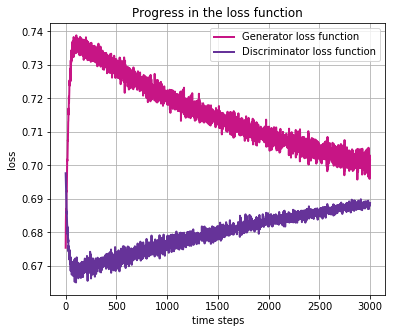

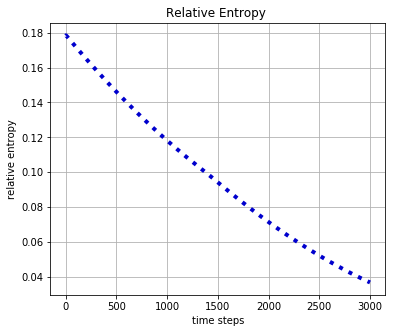

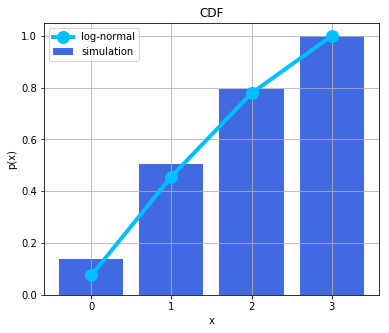

In [9]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_samples(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()